## Preprocessing

In [1]:
with open("task/train.txt") as file:
    data = file.read()
    train_ids=data.split()
with open("task/valid.txt") as file:
    data = file.read()
    test_ids=data.split()

In [2]:
from PIL import Image

def get_image(img_id):
    image = Image.open(f'images/{img_id}.jpg')
    return image

In [3]:
from xml.dom import minidom
def get_svg_polygons(img_id):
    #source: https://stackoverflow.com/a/15857847
    doc = minidom.parse(f'ground-truth/locations/{img_id}.svg')
    path_strings = [path.getAttribute('d') for path
                in doc.getElementsByTagName('path')]
    doc.unlink()
    polygons=[]
    for path_string in path_strings:
        splitted_path_string=path_string.split()
        temp_coor=[]
        polygons.append([])
        for i in range(len(splitted_path_string)):
            if i%3==0 and i!=0:
                polygons[-1].append(tuple(temp_coor))
                temp_coor=[]
            elif i!=0:
                temp_coor.append(float(splitted_path_string[i]))
        
    return polygons

In [4]:
#source: https://stackoverflow.com/a/59208291
def crop(image):
    y_nonzero, x_nonzero, _ = np.nonzero(image<255)
    image = Image.fromarray(image, "RGB")
    return image.crop((np.min(x_nonzero), np.min(y_nonzero), np.max(x_nonzero), np.max(y_nonzero)))

In [5]:
import numpy as np
from PIL import ImageDraw
from IPython.display import display
import cv2

def get_binarized_words(img_id):
    polygons=get_svg_polygons(img_id)

    im=get_image(img_id).convert("RGB")
    imArray = np.asarray(im)
    
    binarized_words=[]

    for polygon in polygons:
        #source: https://stackoverflow.com/a/22650239

        maskIm = Image.new('L', (imArray.shape[1], imArray.shape[0]), 0)
        ImageDraw.Draw(maskIm).polygon(polygon, outline=1, fill=1)
        mask = np.array(maskIm)
        newImArray = np.empty(imArray.shape,dtype='uint8')

        newImArray[:,:,:3] = imArray[:,:,:3]

        newImArray = np.invert(newImArray)

        newImArray[:,:,0] = newImArray[:,:,0] * mask
        newImArray[:,:,1] = newImArray[:,:,1] * mask
        newImArray[:,:,2] = newImArray[:,:,2] * mask

        newImArray = np.invert(newImArray)

        newIm=crop(newImArray)

        img = np.array(newIm)
        img = img[:, :, ::-1].copy() 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        blur = cv2.GaussianBlur(img,(5,5),0)

        _,bin_img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        binarized_words.append(Image.fromarray(bin_img))

    return binarized_words



In [6]:
def get_ground_truth_text(img_id):
    with open("ground-truth/transcription.txt") as file:
        data = file.read()
    ground_truth_text=[]
    for line in data.split('\n')[:-1]:
        doc_id=line.split('-')[0]

        if int(doc_id)==int(img_id):
            ground_truth_text.append(line.split()[-1])
            
    return np.array(ground_truth_text)

In [7]:
import random
train_id=random.choice(train_ids)
test_id=random.choice(test_ids)

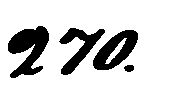

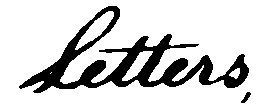

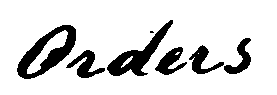

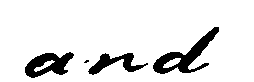

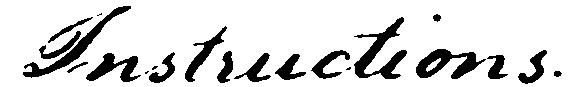

In [8]:
binarized_imgs_train = get_binarized_words(train_id)
binarized_imgs_test = get_binarized_words(test_id)

for img in binarized_imgs_train[:5]:
    display(img)

In [9]:
ground_truth_text_train=get_ground_truth_text(train_id)
ground_truth_text_test=get_ground_truth_text(test_id)

for word in ground_truth_text_train[:5]:
    print(word)

s_2-s_7-s_0-s_pt
L-e-t-t-e-r-s-s_cm
O-r-d-e-r-s
a-n-d
I-n-s-t-r-u-c-t-i-o-n-s-s_pt


## Features creation

In [10]:
import numpy as np

def n_transitions(img):
    n = 0
    for row in img:
        current = row[0]
        for pixel in row[1:]:
            if pixel != current:
                n += 1
                current = pixel
    return n


def upper_contour(img):
    """
    Return an index vector per column (IE window) in the image of the upper contour
    """
    cnt_indices = []
    for row in img:
        row_index = np.argmin(row)
        if row[row_index] != 0:
            cnt_indices.append(-1)
        else:
            cnt_indices.append(row_index)
    
        
    return cnt_indices

def lower_contour(img):
    # flip the img along the pixel rows axis 
    flipped = np.flip(img, axis=1)
    
    # when flipped, upper_contour will return the contour of the pixel rows sorted in inverse order
    reversed_contour = upper_contour(flipped)
    row_size = img.shape[0]
        
    for i in range(row_size):
        if reversed_contour[i] != -1:
            reversed_contour[i] = row_size - reversed_contour[i]
        
    return reversed_contour

def ratio_black_pixels(img):
    zeros = np.where(img==0)
    img_size = img.shape[0] * img.shape[1]
    return len(zeros[0]) / img_size

In [11]:
from PIL import Image
from collections import defaultdict
from scipy.stats import zscore

def create_feature_vector(binarized_imgs):
    # transpose the images so they we can iterate over the array as a sliding window
    transposed_imgs = [np.transpose(np.array(img)) for img in binarized_imgs]
    
    features_dict = {
        'transitions': (n_transitions, int),
        'upper_contour': (upper_contour, (list,list)),
        'lower_contour': (lower_contour, (list,list)),
        'ratio_black_pixels': (ratio_black_pixels, float),
    }

    feature_vectors_dict = defaultdict(list)
    for label, (func, dtype) in features_dict.items():
        for img in transposed_imgs:
            feature_vectors_dict[label].append(func(img))
    feature_vectors_dict = dict(feature_vectors_dict)

    # z-scorify
    for label, feature in feature_vectors_dict.items():
        if features_dict[label][1] == (list,list):
            # flatten 2d lists (scipy zscore doesn't work on 2d array of different size)
            value_list = []
            for i in feature:
                i = np.array(i)
                i = i.tolist()
                value_list.extend(i)
            value_list = np.array(value_list)
            mean_ = np.mean(value_list)
            std_ = np.std(value_list)
            feature = [np.array(i) for i in feature]
            zscored = []
            for f in feature:
                r = (f - mean_) / std_
                zscored.append(r)
            feature_vectors_dict[label] = np.array(zscored)
        else:
            feature = np.array(feature)
            feature_vectors_dict[label] = [np.array([i]) for i in zscore(feature)]

    # create the feature vector
    imgs_feature_vectors = defaultdict(list)
    for label, imgs in feature_vectors_dict.items():
        for i, data in enumerate(imgs):
            imgs_feature_vectors[i].extend(data.tolist())
    return list(dict(imgs_feature_vectors).values())

In [12]:
train_vectors = create_feature_vector(binarized_imgs_train)
test_vectors = create_feature_vector(binarized_imgs_test)

## Distance evaluation / Testing

In [13]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

for i in range(3):
    print(fastdtw(train_vectors[0], train_vectors[i], dist=euclidean)[0])

0.0
269.8508984415651
256.4389005356069


In [ ]:
n = 10
test_vectors_ = test_vectors[:n]
train_vectors_ = train_vectors[:n]

test_vectors_predicted = []

for test_vector in test_vectors_:
    dists = np.array([fastdtw(train_vector, test_vector, dist=euclidean)[0] for train_vector in train_vectors_])
    dists_sorted = sorted(range(len(dists)), key=lambda x:dists[x])
    test_vectors_predicted.append(ground_truth_text_train[dists_sorted])

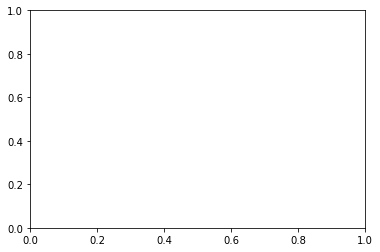

In [18]:
precisions = []
recalls = []

for k in range(1, len(test_vectors_predicted[0])):
    test_predicted_top_k = [i[0:k] for i in test_vectors_predicted]
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for i, predicted_top_k in enumerate(test_predicted_top_k):
        truth = ground_truth_text_test[i]
        if truth in predicted_top_k:
            tp += 1
        
        # todo : find a way to compute the precision and recall with this top predictions
        precision = 0
        recall = 0
        
        precisions.append(precision)
        recalls.append(recall)

import matplotlib.pyplot as plt

plt.plot(precisions, recalls)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()